Code same regardless of literal semantic function

In [51]:
import matplotlib.pyplot as plt
import jax.random as jr
import optax

import jax.numpy as np
import cma
import pandas as pd
from memo import memo
import jax
import jax.numpy as np
from enum import IntEnum, auto
# read in files
# Read UK_df.csv as pandas dataframe
original_UK_dialogue = pd.read_csv('UK_df.csv')
original_UK_politeness = pd.read_csv('UK_direct_df.csv')
original_UK_narrator = pd.read_csv('UK_narrator_df.csv')
original_US_dialogue = pd.read_csv('US_df.csv')
original_US_politeness = pd.read_csv('US_direct_df.csv')
original_US_narrator = pd.read_csv('US_narrator_df.csv')
dataframes = [original_UK_dialogue, original_UK_politeness, original_UK_narrator, original_US_dialogue, original_US_politeness, original_US_narrator]
def elim_outliers(df):
    # dropped Unnamed: 0 column
    df.drop(columns=['Unnamed: 0'], inplace=True)
    filtered_df = df.loc[(df['response'] > 95) | (df['response'] < 5)]
    for id in df['person_id'].unique():
        if len(filtered_df[filtered_df['person_id'] == id])/len(df[df['person_id'] == id])>0.8:
            df.drop(df[df['person_id'] == id].index, inplace=True)
    df['predicate Z-score'] = df.groupby(['person_id','predicate'])['response'].transform(lambda x: (x - x.mean()) / x.std())
    # if has_intensifier = no then change 'intensifier' to 'none'
    df.loc[df['has intensifier?'] == 'no', 'intensifier'] = 'none'
    return df
for i in range(len(dataframes)):
    dataframes[i] = elim_outliers(dataframes[i])
dialogue = pd.concat([dataframes[0], dataframes[3]])
politeness = pd.concat([dataframes[1], dataframes[4]])
UK_dialogue = dataframes[0]
US_dialogue = dataframes[3]
UK_politeness = dataframes[1]
US_politeness = dataframes[4]

# end of reading in data
#-------------------------------------------------------------------------------

# compute U_soc (social Utility)
U_soc_data = politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()
UK_U_soc_data = UK_politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()
US_U_soc_data = US_politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()
class W(IntEnum):  # utterance space
    # intensifiers
    none = auto(0)
    slightly= auto()
    kind_of = auto()
    quite = auto()
    very= auto()
    extremely= auto()

class P(IntEnum):
    # predicates
    boring = auto(0)
    concerned = auto()
    difficult = auto()
    exhausted = auto()
    helpful = auto()
    impressive = auto()
    understandable = auto()
epsilon = 0.01
infty = 10000000
utterences =list(U_soc_data.keys())
easy_S = np.arange(-2.8,2.8,0.1)

# Create a list of JAX arrays
UK_measured_values = []
for p in P:
    for w in W:
        intensifier = w.name.replace('_'," ")
        predicate = p.name
        raw_values = UK_dialogue[((UK_dialogue['intensifier'] == intensifier) & (UK_dialogue['predicate'] == predicate))]['predicate Z-score'].values
        # measured_values.append(np.array([int(r/0.28)+10 for r in raw_values]))
        z = [int(r*10)+28 for r in raw_values]
        x = [0]*len(easy_S)
        for i in z:
           x[i] += 1
        UK_measured_values.append(x)
UK_measured_values = np.array(UK_measured_values)

@jax.jit
def state_prior(s):
    return np.exp(-s**2/2) # we assume s is roughly a gaussian distribution

@jax.jit
def UK_U_soc(intensifier,predicate):
    arr = np.array([
        [UK_U_soc_data[(w.name.replace('_'," "),p.name)] for p in P] 
        for w in W
    ])
    return arr[intensifier,predicate]

@jax.jit
def is_costly(w):
    arr = [0, 1, 1, 1, 1, 1]
    return np.array(arr)[w]

### up down double threshold

In [ ]:
@jax.jit
def up_down_L(w, s,t0,t1,t2,t3,t4,t5,v0,v1, v2, v3, v4, v5):  # literal likelihood L(w | s)
    low_t = np.array([t0,t1,t2,t3,t4,t5])[w]
    high_t = np.array([v0,v1, v2, v3, v4, v5])[w]  # Variance parameters for each intensifier
    s1 = jax.nn.sigmoid(((s - low_t) * 20).astype(float))
    s2 = jax.nn.sigmoid(((high_t - s) * 20).astype(float))
    return s1 * s2
@memo
def up_down_UKL1[s: easy_S, w: W](inf_term, soc_term, cost,t0,t1,t2,t3,t4,t5,v0,v1, v2, v3, v4, v5,p):
    listener: thinks[
        speaker: given(s in easy_S, wpp=state_prior(s)),
        speaker: chooses(w in W, wpp=
            imagine[
                listener: knows(w),
                listener: chooses(s in easy_S, wpp=up_down_L(w, s,t0,t1,t2,t3,t4,t5,v0, v1, v2, v3, v4, v5)), # L(w|s) = literal likelihood,
                exp(0.3*inf_term * log(Pr[listener.s == s]+0.0000001) +
                0.5*soc_term * UK_U_soc(w,p) - # U_soc = listener's EU
                10*cost*is_costly(w)) # U_inf = listener's surprisal       
            ]
        )
    ]
    listener: observes[speaker.w] is w
    listener: chooses(s in easy_S, wpp=Pr[speaker.s == s])
    return Pr[listener.s == s]
def up_down_UK_logloss(*params):
    thetas = params[:6]
    cost = params[6]
    inf_term = params[7]
    soc_term = params[8]
    var = params[9:15]  # Extract the variance parameters
    P_l1 = np.concatenate([up_down_UKL1(inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5],v0 = var[0], v1=var[1], v2= var[2], v3 = var[3], v4 = var[4], v5 = var[5], p=p) for p in P],axis = 1)
    return np.sum(np.log(P_l1)*UK_measured_values.T)
def up_down_wrapped_loss(x):
    result = up_down_UK_logloss(*tuple(x))  # Unpack the parameters from the tuple
    return -result.item()
best_params_arr = []
best_values_arr = []
key = jr.PRNGKey(42)  # Random seed
keys = jr.split(key, 100)  # Generate 10 random keys
for m in range(100):
    initial_val = list(jr.uniform(keys[m], shape=(9,), minval=-3, maxval=3))+ list(jr.uniform(keys[m], shape=(6,), minval=0, maxval= 3))  # Generate 6 random numbers between 0 and 3
    print(m,"initial value:",initial_val) 
    for sigma in [0.1, 0.5,1]:
        best_params_list = []
        best_values_list = []
        for _ in range(3):
            # Get best solution
            es = cma.CMAEvolutionStrategy(
                initial_val,    # initial guess
                sigma, # sigma
                {"bounds": [None, None]},
            )
            es.optimize(up_down_wrapped_loss)
            best_params = es.result.xbest
            best_value = -es.result.fbest  # Negate to get the original loss value
            print(es.stop())
            print("Best value found:", best_value)
            print("Best parameters found:", best_params)
            best_params_list.append(best_params)
            best_values_list.append(best_value)
        best_params_arr.append(best_params_list)
        best_values_arr.append(best_values_list)
    # if m%10==0:
    #     onp.save(f'cma_best_params.npy', best_params_arr)
    #     onp.save(f'cma_best_values.npy', best_values_arr)

In [45]:
best_params = [-1.0513446 , -2.7592294,  -1.240721,   -1.3021916,   0.70207274,  1.1027944, -2.1221278,   0.5323107,   0.49295557, 
 2.0665731, 1.7485677, 0.7736569, 1.8275299, 0.5520223, 1.3690932 ]
for i in range(1,7):
    best_params[-i] = best_params[-i]+best_params[6-i]
print(best_params)
up_down_wrapped_loss(best_params)


[-1.0513446, -2.7592294, -1.240721, -1.3021916, 0.70207274, 1.1027944, -2.1221278, 0.5323107, 0.49295557, 1.0152284999999999, -1.0106617000000002, -0.4670641, 0.5253383, 1.25409504, 2.4718876]


5074.888671875

### normal cdf

In [ ]:
from jax.scipy.special import ndtr
import jax.numpy as np
@jax.jit
def ndtr_L(w, s,t0,t1,t2,t3,t4,t5,v0,v1, v2, v3, v4, v5):  # literal likelihood L(w | s)
    t = np.array([t0,t1,t2,t3,t4,t5])[w]
    var = np.array([v0,v1,v2,v3,v4,v5])[w]  # Variance parameters for each intensifier
    return ndtr((s-t)/np.sqrt(var))
@memo
def ndtr_UKL1[s: easy_S, w: W](inf_term, soc_term, cost,t0,t1,t2,t3,t4,t5,v0,v1, v2, v3, v4, v5,p):
    listener: thinks[
        speaker: given(s in easy_S, wpp=state_prior(s)),
        speaker: chooses(w in W, wpp=
            imagine[
                listener: knows(w),
                listener: chooses(s in easy_S, wpp=ndtr_L(w, s,t0,t1,t2,t3,t4,t5,v0, v1, v2, v3, v4, v5)), # L(w|s) = literal likelihood,
                exp(0.3*inf_term * log(Pr[listener.s == s]+0.0000001) +
                0.5*soc_term * UK_U_soc(w,p) - # U_soc = listener's EU
                10*cost*is_costly(w)) # U_inf = listener's surprisal       
            ]
        )
    ]
    listener: observes[speaker.w] is w
    listener: chooses(s in easy_S, wpp=Pr[speaker.s == s])
    return Pr[listener.s == s]
def ndtr_UK_logloss(*params):
    thetas = params[:6]
    cost = params[6]
    inf_term = params[7]
    soc_term = params[8]
    var = params[9:15]  # Extract the variance parameters
    P_l1 = np.concatenate([ndtr_UKL1(inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5],v0 = var[0], v1=var[1], v2= var[2], v3 = var[3], v4 = var[4], v5 = var[5], p=p) for p in P],axis = 1)
    return np.sum(np.log(P_l1)*UK_measured_values.T)
def ndtr_wrapped_loss(x):
    result = ndtr_UK_logloss(*tuple(x))  # Unpack the parameters from the tuple
    return -result.item()
best_params_arr = []
best_values_arr = []
key = jr.PRNGKey(42)  # Random seed
keys = jr.split(key, 100)  # Generate 10 random keys
for m in range(100):
    initial_val = list(jr.uniform(keys[m], shape=(9,), minval=-3, maxval=3))+ list(jr.uniform(keys[m], shape=(6,), minval=0, maxval= 3))  # Generate 6 random numbers between 0 and 3
    print(m,"initial value:",initial_val) 
    for sigma in [0.1, 0.5,1]:
        best_params_list = []
        best_values_list = []
        for _ in range(3):
            # Get best solution
            es = cma.CMAEvolutionStrategy(
                initial_val,    # initial guess
                sigma, # sigma
                {"bounds": [None, None]},
            )
            es.optimize(ndtr_wrapped_loss)
            best_params = es.result.xbest
            best_value = -es.result.fbest  # Negate to get the original loss value
            print(es.stop())
            print("Best value found:", best_value)
            print("Best parameters found:", best_params)
            best_params_list.append(best_params)
            best_values_list.append(best_value)
        best_params_arr.append(best_params_list)
        best_values_arr.append(best_values_list)

In [86]:
best_params = [-2.949469804763794, -3.3657734394073486, -3.0427451133728027, -2.3355953693389893, -2.1554062366485596, 51.493316650390625, -7.575220584869385, 64.18766784667969, 0.8161790370941162, 2.719905138015747, 1.0315154790878296, 1.4429823160171509, 0.5950062870979309, 7.180896759033203, 472.73272705078125]
ndtr_wrapped_loss(best_params)

5091.65478515625

### step function

In [ ]:
import jax.numpy as np
@jax.jit
def step_L(w, s,t0,t1,t2,t3,t4,t5):  # literal likelihood L(w | s)
    t = np.array([t0,t1,t2,t3,t4,t5])[w]
    sigt = 1 / (1 + np.exp(-t))
    threshold = sigt * 5.6 - 2.8
    return jax.lax.cond(
        threshold> s,
        lambda: epsilon,  # If condition (t > s) is True
        lambda: (5.6 - epsilon * (threshold+2.8)) / (2.8 - threshold)  # s and threshold can range from -2.8 to 2.8
    )

@memo
def step_UKL1[s: easy_S, w: W](inf_term, soc_term, cost,t0,t1,t2,t3,t4,t5,p):
    listener: thinks[
        speaker: given(s in easy_S, wpp=state_prior(s)),
        speaker: chooses(w in W, wpp=
            imagine[
                listener: knows(w),
                listener: chooses(s in easy_S, wpp=step_L(w, s,t0,t1,t2,t3,t4,t5)) ,
                exp(inf_term * log(Pr[listener.s == s]) + 
                soc_term * UK_U_soc(w,p) - # U_soc = listener's EU
                cost*is_costly(w)) # U_inf = listener's surprisal       
            ]
        )
    ]
    listener: observes[speaker.w] is w
    listener: chooses(s in easy_S, wpp=Pr[speaker.s == s])
    return Pr[listener.s == s]
def step_UK_logloss(*params):
    thetas = params[:6]
    cost = params[6]
    inf_term = params[7]
    soc_term = params[8]
    P_l1 = np.concatenate([step_UKL1(inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5],p=p) for p in P],axis = 1)
    return np.sum(np.log(P_l1)*UK_measured_values.T)
def step_wrapped_loss(x):
    result = step_UK_logloss(*tuple(x))  # Unpack the parameters from the tuple
    return -result.item()
best_params_arr = []
best_values_arr = []
key = jr.PRNGKey(42)  # Random seed
keys = jr.split(key, 100)  # Generate 10 random keys
for m in range(100):
    initial_val = list(jr.uniform(keys[m], shape=(9,), minval=-3, maxval=3))# Generate 6 random numbers between 0 and 3
    print(m,"initial value:",initial_val) 
    for sigma in [0.1, 0.5,1]:
        best_params_list = []
        best_values_list = []
        for _ in range(3):
            # Get best solution
            es = cma.CMAEvolutionStrategy(
                initial_val,    # initial guess
                sigma, # sigma
                {"bounds": [None, None]},
            )
            es.optimize(step_wrapped_loss)
            best_params = es.result.xbest
            best_value = -es.result.fbest  # Negate to get the original loss value
            print(es.stop())
            print("Best value found:", best_value)
            print("Best parameters found:", best_params)
            best_params_list.append(best_params)
            best_values_list.append(best_value)
        best_params_arr.append(best_params_list)
        best_values_arr.append(best_values_list)

In [65]:
best_params = [-0.36101093888282776, 3.4037907123565674, -1.2989978790283203, -1.3608115911483765, 0.143044114112854, 0.6664467453956604, 0.46092426776885986, 0.39644140005111694, 0.7771433591842651, -0.37685564160346985, 3.991560935974121, -0.7233627438545227, 0.9365357756614685, -0.6776830554008484, 0.9582012891769409]
step_wrapped_loss(best_params)

5193.501953125

### gaussian literal semantics

In [ ]:
@jax.jit
def gaussian_L(w, s,t0,t1,t2,t3,t4,t5,v0,v1, v2, v3, v4, v5):  # literal likelihood L(w | s)
    t = np.array([t0,t1,t2,t3,t4,t5])[w]
    v = np.array([v0,v1, v2, v3, v4, v5])[w]  # Variance parameters for each intensifier
    return np.exp(-(t-s)**2/v)

@memo
def gaussian_UKL1[s: easy_S, w: W](inf_term, soc_term, cost,t0,t1,t2,t3,t4,t5,v0,v1, v2, v3, v4, v5,p):
    listener: thinks[
        speaker: given(s in easy_S, wpp=state_prior(s)),
        speaker: chooses(w in W, wpp=
            imagine[
                listener: knows(w),
                listener: chooses(s in easy_S, wpp=gaussian_L(w, s,t0,t1,t2,t3,t4,t5,v0, v1, v2, v3, v4, v5)), # L(w|s) = literal likelihood,
                exp(0.3*inf_term * log(Pr[listener.s == s]+0.0000001) +
                0.5*soc_term * UK_U_soc(w,p) - # U_soc = listener's EU
                10*cost*is_costly(w)) # U_inf = listener's surprisal       
            ]
        )
    ]
    listener: observes[speaker.w] is w
    listener: chooses(s in easy_S, wpp=Pr[speaker.s == s])
    return Pr[listener.s == s]


def gaussian_UK_logloss(*params):
    thetas = params[:6]
    cost = params[6]
    inf_term = params[7]
    soc_term = params[8]
    var = params[9:15]  # Extract the variance parameters
    P_l1 = np.concatenate([gaussian_UKL1(inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5],v0 = var[0], v1=var[1], v2= var[2], v3 = var[3], v4 = var[4], v5 = var[5], p=p) for p in P],axis = 1)
    return np.sum(np.log(P_l1)*UK_measured_values.T)

def gaussian_wrapped_loss(x):
    result = gaussian_UK_logloss(*tuple(x))  # Unpack the parameters from the tuple
    return -result.item()
best_params_arr = []
best_values_arr = []
key = jr.PRNGKey(2)  # Random seed
keys = jr.split(key, 100)  # Generate 10 random keys
for m in range(100):
    initial_val = list(jr.uniform(keys[m], shape=(9,), minval=-3, maxval=3))+ list(jr.uniform(keys[m], shape=(6,), minval=0, maxval= 3))  # Generate 6 random numbers between 0 and 3
    print(m,"initial value:",initial_val) 
    for sigma in [0.1, 0.5,1]:
        best_params_list = []
        best_values_list = []
        for _ in range(3):
            # Get best solution
            es = cma.CMAEvolutionStrategy(
                initial_val,    # initial guess
                sigma, # sigma
                {"bounds": [None, None]},
            )
            es.optimize(gaussian_wrapped_loss)
            best_params = es.result.xbest
            best_value = -es.result.fbest  # Negate to get the original loss value
            print(es.stop())
            print("Best value found:", best_value)
            print("Best parameters found:", best_params)
            best_params_list.append(best_params)
            best_values_list.append(best_value)
        best_params_arr.append(best_params_list)
        best_values_arr.append(best_values_list)
    # if m%10==0:
    #     onp.save(f'cma_best_params.npy', best_params_arr)
    #     onp.save(f'cma_best_values.npy', best_values_arr)



In [46]:
best_params = [ 1.5358961e-01, -6.0291225e+01, -3.6772674e-01, -1.6357814e-01,
  7.2905082e-01,  1.8944669e+00,  4.7870338e-02,  7.0266885e-01,
  4.5761219e-01,  1.3582440e-01,  4.2318684e+01,  2.2597484e-01,
  2.2386873e-01,  9.5187336e-02,  6.1780596e-01]
print(gaussian_wrapped_loss(best_params))

5059.4619140625


### fitting literal listener

In [ ]:
@memo
def literal_UKL1[s: easy_S, w: W](t0,t1,t2,t3,t4,t5,v0,v1, v2, v3, v4, v5,p):
    listener: thinks[
        speaker: given(s in easy_S, wpp=state_prior(s)),
        speaker: chooses(w in W, wpp=gaussian_L(w, s,t0,t1,t2,t3,t4,t5,v0, v1, v2, v3, v4, v5))
    ]
    listener: observes[speaker.w] is w
    listener: chooses(s in easy_S, wpp=Pr[speaker.s == s])
    return Pr[listener.s == s]

def literal_UK_logloss(*params):
    thetas = params[:6]
    var = params[6:12]  # Extract the variance parameters
    P_l1 = np.concatenate([literal_UKL1(t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5],v0 = var[0], v1=var[1], v2= var[2], v3 = var[3], v4 = var[4], v5 = var[5], p=p) for p in P],axis = 1)
    return np.sum(np.log(P_l1)*UK_measured_values.T)

def literal_wrapped_loss(x):
    result = literal_UK_logloss(*tuple(x))  # Unpack the parameters from the tuple
    return -result.item()

best_params_arr = []
best_values_arr = []
key = jr.PRNGKey(42)  # Random seed
keys = jr.split(key, 1000)  # Generate 10 random keys
for m in range(1000):
    initial_val = list(jr.uniform(keys[m], shape=(6,), minval=-3, maxval=3))+ list(jr.uniform(keys[m], shape=(6,), minval=0, maxval= 3))  # Generate 6 random numbers between 0 and 3
    print("initial value:",initial_val) 
    for sigma in [0.1, 0.5,1]:
        best_params_list = []
        best_values_list = []
        for _ in range(3):
            # Get best solution
            es = cma.CMAEvolutionStrategy(
                initial_val,    # initial guess
                sigma, # sigma
                {"bounds": [[None]*6+[0]*6, None],'tolfunhist': 1e-16,'tolflatfitness': 10,'tolfun': 1e-12},
            )
            es.optimize(literal_wrapped_loss)
            best_params = es.result.xbest
            best_value = -es.result.fbest  # Negate to get the original loss value
            print(es.stop())
            print("Best value found:", best_value)
            print("Best parameters found:", best_params)
            best_params_list.append(best_params)
            best_values_list.append(best_value)
        best_params_arr.append(best_params_list)
        best_values_arr.append(best_values_list)

In [72]:
best_params = [ 0.03791361, -4.675335,   -0.51390004, -0.29339173,  0.67415667, 2.9828167,
  0.9959588, 10.043099, 1.5483093, 1.1008468, 0.80999833, 8.441318]
print(literal_wrapped_loss(best_params))

5091.37255859375


Intensifier none: Mean = 0.0379, Variance = 0.9960, Std Dev = 0.9980
Intensifier slightly: Mean = -4.6753, Variance = 10.0431, Std Dev = 3.1691
Intensifier kind_of: Mean = -0.5139, Variance = 1.5483, Std Dev = 1.2443
Intensifier quite: Mean = -0.2934, Variance = 1.1008, Std Dev = 1.0492
Intensifier very: Mean = 0.6742, Variance = 0.8100, Std Dev = 0.9000
Intensifier extremely: Mean = 2.9828, Variance = 8.4413, Std Dev = 2.9054


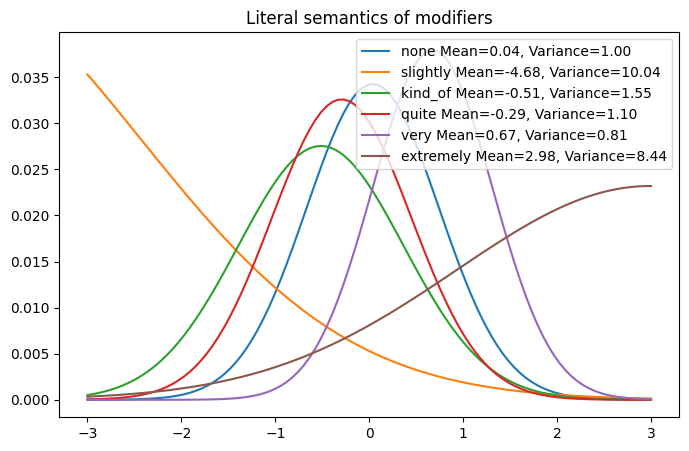

Intensifier none: Mean = 0.0379, Variance = 0.9960, Std Dev = 0.9980
Intensifier slightly: Mean = -4.6753, Variance = 10.0431, Std Dev = 3.1691
Intensifier kind_of: Mean = -0.5139, Variance = 1.5483, Std Dev = 1.2443
Intensifier quite: Mean = -0.2934, Variance = 1.1008, Std Dev = 1.0492
Intensifier very: Mean = 0.6742, Variance = 0.8100, Std Dev = 0.9000
Intensifier extremely: Mean = 2.9828, Variance = 8.4413, Std Dev = 2.9054


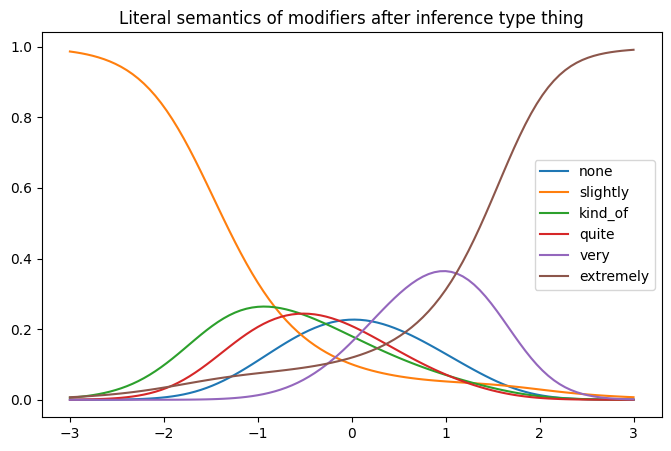

In [79]:
# plot graph of literal semantics
import numpy as np
import matplotlib.pyplot as plt
best_params_list = best_params
plt.figure(figsize=(8, 5))
x = np.linspace(-3, 3, 100)
for i in range(6):
    mean = best_params_list[i]
    variance = best_params_list[6+i]  # Assuming the variance is in the last 6 columns
    std_dev = np.sqrt(variance)
    print(f"Intensifier {W(i).name}: Mean = {mean:.4f}, Variance = {variance:.4f}, Std Dev = {std_dev:.4f}")
    y = np.exp(-(x-mean)**2/variance)
    y/=sum(y)
    plt.plot(x, y, label=f'{W(i).name} Mean={mean :.2f}, Variance={variance:.2f}'.format(mean, variance))
plt.legend()
plt.title('Literal semantics of modifiers')
plt.show()
# plot graph of L1 pragmatic listener
plt.figure(figsize=(8, 5))
y_array = []
inf_term = 1
for i in range(6):
    mean = best_params_list[i]
    variance = best_params_list[6+i]  # Assuming the variance is in the last 6 columns
    std_dev = np.sqrt(variance)
    print(f"Intensifier {W(i).name}: Mean = {mean:.4f}, Variance = {variance:.4f}, Std Dev = {std_dev:.4f}")
    y = np.exp(-(x-mean)**2/variance)*np.exp(-x**2/2)
    y/=sum(y)
    y_array.append(y)
# normalize each columng in y_array
y_array = np.array(y_array)
y_array**inf_term
y_array /= y_array.sum(axis=0, keepdims=True)
for i in range(6):
    plt.plot(x, y_array[i], label=f'{W(i).name}')
plt.legend()
plt.title('Literal semantics of modifiers after inference type thing')
plt.show()


### one and two thresholds (defined by thresholds of amplifiers being inf)

In [ ]:
@jax.jit
def up_down_L(w, s,t0,t1,t2,t3,t4,t5,v0,v1, v2, v3, v4, v5):  # literal likelihood L(w | s)
    low_t = np.array([t0,t1,t2,t3,t4,t5])[w]
    high_t = np.array([v0,v1, v2, v3, v4, v5])[w]  # Variance parameters for each intensifier
    s1 = jax.nn.sigmoid(((s - low_t) * 20).astype(float))
    s2 = jax.nn.sigmoid(((high_t - s) * 20).astype(float))
    return s1 * s2
@memo
def up_down_UKL1[s: easy_S, w: W](inf_term, soc_term, cost,t0,t1,t2,t3,t4,t5,v0,v1, v2, v3, v4, v5,p):
    listener: thinks[
        speaker: given(s in easy_S, wpp=state_prior(s)),
        speaker: chooses(w in W, wpp=
            imagine[
                listener: knows(w),
                listener: chooses(s in easy_S, wpp=up_down_L(w, s,t0,t1,t2,t3,t4,t5,v0, v1, v2, v3, v4, v5)), # L(w|s) = literal likelihood,
                exp(0.3*inf_term * log(Pr[listener.s == s]+0.0000001) +
                0.5*soc_term * UK_U_soc(w,p) - # U_soc = listener's EU
                10*cost*is_costly(w)) # U_inf = listener's surprisal       
            ]
        )
    ]
    listener: observes[speaker.w] is w
    listener: chooses(s in easy_S, wpp=Pr[speaker.s == s])
    return Pr[listener.s == s]
def up_down_UK_logloss(*params):
    thetas = params[:6]
    cost = params[6]
    inf_term = params[7]
    soc_term = params[8]
    var = params[9:15]  # Extract the variance parameters
    P_l1 = np.concatenate([up_down_UKL1(inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5],v0 = var[0], v1=var[1], v2= var[2], v3 = var[3], v4 = var[4], v5 = var[5], p=p) for p in P],axis = 1)
    return np.sum(np.log(P_l1)*UK_measured_values.T)
def up_down_wrapped_loss(x):
    result = up_down_UK_logloss(*tuple(x))  # Unpack the parameters from the tuple
    return -result.item()
best_params_arr = []
best_values_arr = []
inf = 1000000
key = jr.PRNGKey(42)  # Random seed
keys = jr.split(key, 100)  # Generate 10 random keys
for m in range(100):
    initial_val = list(jr.uniform(keys[m], shape=(9,), minval=-3, maxval=3))+ list(jr.uniform(keys[m], shape=(6,), minval=0, maxval= 3))  # Generate 6 random numbers between 0 and 3
    print(m,"initial value:",initial_val) 
    initial_val[-2]=inf
    initial_val[-1]=inf
    for sigma in [0.1, 0.5,1]:
        best_params_list = []
        best_values_list = []
        for _ in range(3):
            # Get best solution
            es = cma.CMAEvolutionStrategy(
                initial_val,    # initial guess
                sigma, # sigma
                {"bounds": [[None]*13+[inf-0.1]*2, [None]*13+[inf]*2]},
            )
            es.optimize(up_down_wrapped_loss)
            best_params = es.result.xbest
            best_value = -es.result.fbest  # Negate to get the original loss value
            print(es.stop())
            print("Best value found:", best_value)
            print("Best parameters found:", best_params)
            best_params_list.append(best_params)
            best_values_list.append(best_value)
        best_params_arr.append(best_params_list)
        best_values_arr.append(best_values_list)

In [ ]:
best_params = [-1.0912045, -3.9391491, -1.2519991, -1.3153936, 0.60801125, 1.1688915, -4.1515212, 0.53718007,
  0.50815403,  0.99900305, -1.0161099, -0.47953877,
  0.50213414, 9.9999994e5, 1.0000000e6]
print(up_down_UK_logloss(*best_params))
# plot literal semantics and literal semantics marginalized over alternative utterances

-5080.5317
